# Análise explorátoria dos dados de treino/teste

https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets

In [1]:
import os
import shutil
import duckdb
import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

Carregar os dados pré-processados obtidos do repositorio do kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_notarget.parquet'  ,'/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


Carregar os dados de treino e teste

In [3]:
df = pd.read_parquet('./datasets/df_train_test.parquet', engine='pyarrow')
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,Debit (Prepaid),5497590243197280,07/2022,306,YES,2,55.0,05/2008,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,Credit,5175842699412235,12/2024,438,YES,1,9100.0,09/2005,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,Debit,5874992802287595,05/2020,256,YES,1,14802.0,01/2006,2008,No
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,Debit,4354185735186651,01/2020,120,YES,1,19113.0,07/2009,2014,No
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,Debit (Prepaid),5207231566469664,03/2014,198,YES,1,89.0,01/2008,2015,No


In [4]:
df['id'] = df['id'].astype(str)
df['client_id'] = df['client_id'].astype(str)
df['card_id'] = df['card_id'].astype(str)
df['merchant_id'] = df['merchant_id'].astype(str)
df['zip'] = df['zip'].astype(str)
df['card_number'] = df['card_number'].astype(str)
df['cvv'] = df['cvv'].astype(str)
df['birth_year'] = df['birth_year'].astype(str)
df['birth_month'] = df['birth_month'].astype(str)


1. **id**: Identificador único da transação.
2. **date**: Data em que a transação foi realizada.
3. **client_id**: Identificador único do cliente.
4. **card_id**: Identificador único do cartão utilizado na transação.
5. **amount**: Valor da transação.
6. **use_chip**: Indicador se a transação foi efetuada com o uso de chip (sim/não).
7. **merchant_id**: Identificador do comerciante onde a transação foi realizada.
8. **merchant_city**: Cidade onde está localizado o comerciante.
9. **merchant_state**: Estado onde está localizado o comerciante.
10. **zip**: Código postal do local do comerciante.
11. **mcc**: Código de Categoria do Comerciante, que indica o tipo de negócio ou setor do comerciante.
12. **errors**: Indicador de erros ocorridos durante a transação.
13. **description**: Descrição ou comentário associado à transação.
14. **target**: Indicador se a transação foi fraudulenta (Yes) ou não (No).
15. **current_age**: Idade atual do cliente.
16. **retirement_age**: Idade de aposentadoria do cliente.
17. **birth_year**: Ano de nascimento do cliente.
18. **birth_month**: Mês de nascimento do cliente.
19. **gender**: Gênero do cliente.
20. **address**: Endereço residencial do cliente.
21. **latitude**: Latitude do endereço do cliente.
22. **longitude**: Longitude do endereço do cliente.
23. **per_capita_income**: Renda per capita do cliente ou região.
24. **yearly_income**: Renda anual do cliente.
25. **total_debt**: Dívida total do cliente.
26. **credit_score**: Pontuação de crédito do cliente.
27. **num_credit_cards**: Número de cartões de crédito que o cliente possui.
28. **card_brand**: Bandeira do cartão utilizado na transação (Visa, Mastercard, etc.).
29. **card_type**: Tipo do cartão (crédito, débito, etc.).
30. **card_number**: Número do cartão utilizado na transação.
31. **expires**: Data de expiração do cartão.
32. **cvv**: Código de segurança do cartão.
33. **has_chip**: Indicador se o cartão possui chip (sim/não).
34. **num_cards_issued**: Número de cartões emitidos para o cliente.
35. **credit_limit**: Limite de crédito do cartão.
36. **acct_open_date**: Data de abertura da conta do cliente.
37. **year_pin_last_cha**: Ano da última alteração do PIN do cartão.
38. **card_on_dark_web**: Indicador se o cartão foi encontrado em listas de venda na dark web.

In [52]:
def get_outliers(df, column, min_zero = True):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  if min_zero:
    lower_bound = lower_bound if lower_bound >= 0 else 0
  upper_bound = Q3 + 1.5 * IQR
  if min_zero:
    upper_bound = upper_bound if upper_bound >= 0 else 0

  return lower_bound, upper_bound

## Análise Temporal

Vamos analisar os dados com base na caracteristica tempo a fim de entender as caracteristicas das transações

### Análise diaria

In [5]:
df_time_day = pd.DataFrame()
df_time_day['day'] = df['date'].dt.to_period('D')
df_time_day['target'] = df['target'].apply(lambda x: 1 if x == 'Yes' else 0)
df_time_day['amount'] = df['amount']
df_time_day.head()

,day,target,amount
0,2010-01-01,0,-77.00
1,2010-01-01,0,14.57
2,2010-01-01,0,80.00
3,2010-01-01,0,46.41
4,2010-01-01,0,4.81


In [6]:
df_transactions_day = df_time_day.groupby(by='day').agg({'amount': ['sum', 'count'], 'target': 'sum'}).reset_index()
df_transactions_day.columns = ['day', 'amount', 'transactions', 'total_frauds']
df_transactions_day['mean_amount'] = (df_transactions_day['amount'] / df_transactions_day['transactions']).round(2)
df_transactions_day['has_fraud'] = df_transactions_day['total_frauds'] > 0
df_transactions_day.head()

,day,amount,transactions,total_frauds,mean_amount,has_fraud
0,2010-01-01,80720.21,2329,1,34.66,True
1,2010-01-02,93346.82,1971,0,47.36,False
2,2010-01-03,93505.91,2201,1,42.48,True
3,2010-01-04,91449.68,2216,2,41.27,True
4,2010-01-05,100216.52,2269,1,44.17,True


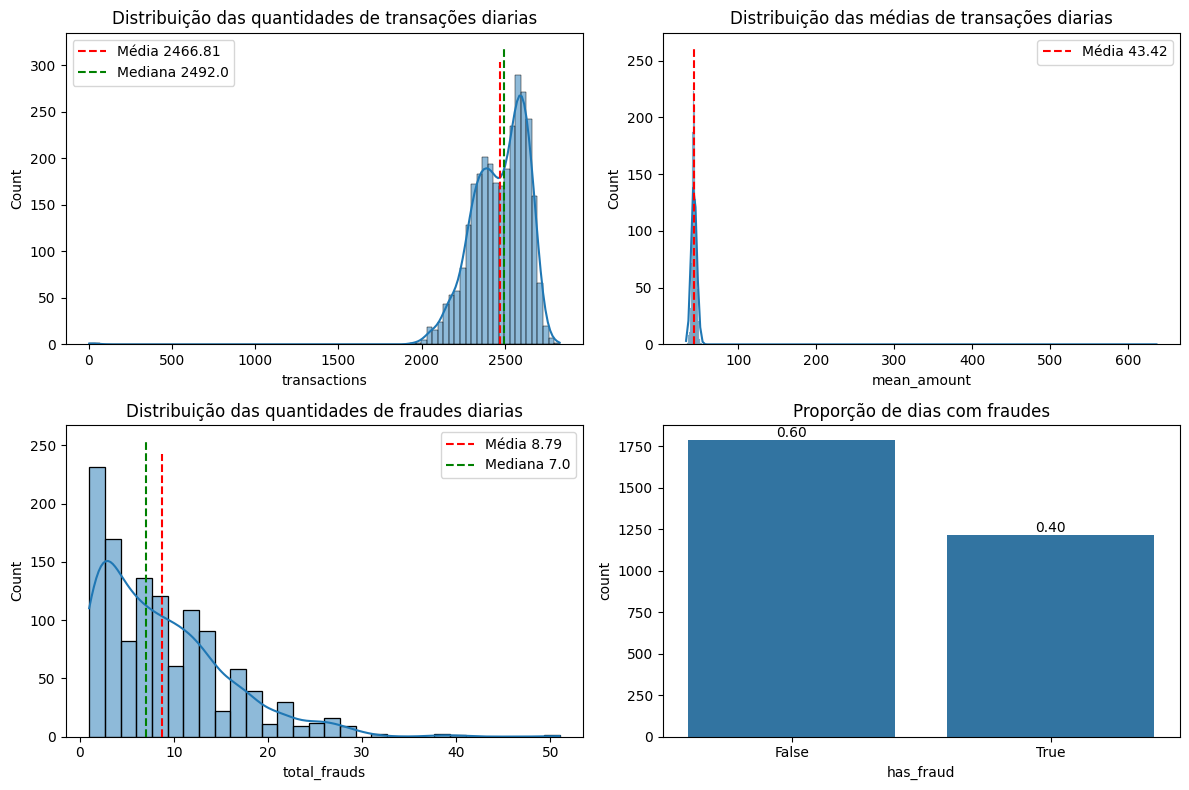

In [48]:
plt.figure(figsize=(12, 8))
plt.subplot(221)

plt.title('Distribuição das quantidades de transações diarias')
ax = sns.histplot(df_transactions_day['transactions'], kde=True)
ax.vlines(df_transactions_day['transactions'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day["transactions"].mean(), 2)}')
ax.vlines(df_transactions_day['transactions'].median(), 0, ax.get_ylim()[1], color='green', linestyles='dashed', label=f'Mediana {round(df_transactions_day["transactions"].median(), 2)}')
ax.legend()

plt.subplot(222)
plt.title('Distribuição das médias de transações diarias')
ax = sns.histplot(df_transactions_day['mean_amount'], kde=True)
ax.vlines(df_transactions_day['mean_amount'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day["mean_amount"].mean(), 2)}' )
ax.legend()

plt.subplot(223)
plt.title('Distribuição das quantidades de fraudes diarias')
ax = sns.histplot(df_transactions_day.query('total_frauds > 0')['total_frauds'], kde=True)
ax.vlines(df_transactions_day.query('total_frauds > 0')['total_frauds'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day.query("total_frauds > 0")["total_frauds"].mean(), 2)}')
ax.vlines(df_transactions_day.query('total_frauds > 0')['total_frauds'].median(), 0, ax.get_ylim()[1], color='green', linestyles='dashed', label=f'Mediana {round(df_transactions_day.query("total_frauds > 0")["total_frauds"].median(), 2)}')
ax.legend()

plt.subplot(224)
plt.title('Proporção de dias com fraudes')
ax = sns.countplot(data=df_transactions_day, x='has_fraud')

total = len(df_transactions_day)
for path in ax.patches:
  ax.annotate(f'{path.get_height()/total:.2f}', (path.get_x() + path.get_width() / 2., path.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

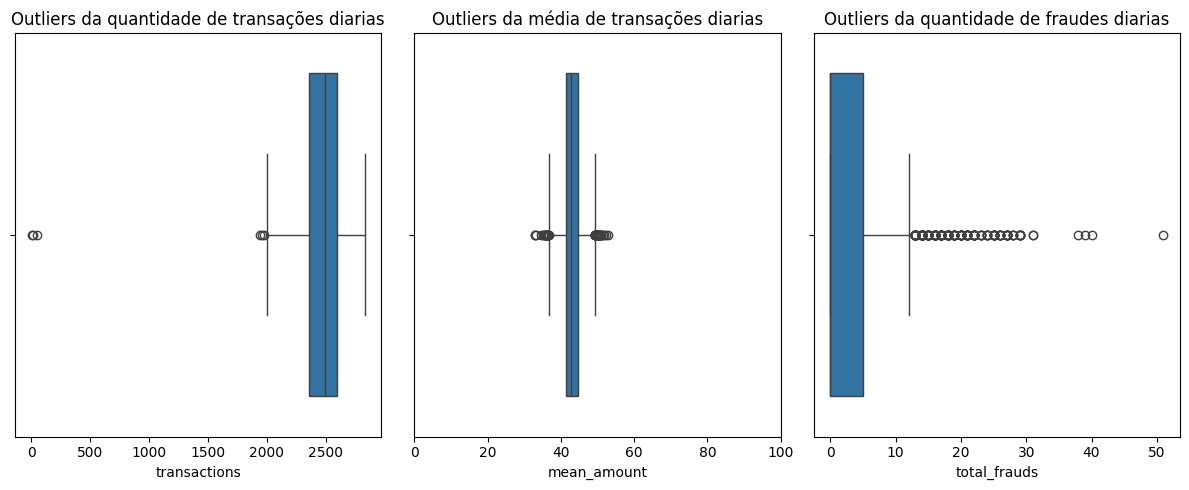

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(131)
plt.title('Outliers da quantidade de transações diarias')
ax = sns.boxplot(x=df_transactions_day['transactions'])

plt.subplot(132)
plt.title('Outliers da média de transações diarias')
ax = sns.boxplot(x=df_transactions_day['mean_amount'])
ax.set_xlim(0, 100)

plt.subplot(133)
plt.title('Outliers da quantidade de fraudes diarias')
ax = sns.boxplot(x=df_transactions_day['total_frauds'])

plt.tight_layout()
plt.show()

In [17]:
stat, p = stats.shapiro(df_transactions_day['transactions'])

alpha = 0.05

if p > alpha:
    print('A amostra provavelmente segue uma distribuição normal (falha ao rejeitar H0)')
else:
    print('A amostra provavelmente não segue uma distribuição normal (rejeita H0)')

A amostra provavelmente não segue uma distribuição normal (rejeita H0)


In [53]:
min, max = get_outliers(df_transactions_day, 'transactions')
print('Outlier min:', min)
print('Outlier max:', max)

Outlier min: 1996.0
Outlier max: 2956.0


In [54]:
min, max = get_outliers(df_transactions_day, 'mean_amount')
print('Outlier min:', round(min, 2))
print('Outlier max:', round(max, 2))

Outlier min: 36.67
Outlier max: 49.34


In [55]:
min, max = get_outliers(df_transactions_day, 'total_frauds')
print('Outlier min:', round(min, 2))
print('Outlier max:', round(max, 2))

Outlier min: 0
Outlier max: 12.5


Análises

> Quantidade de transações por dia

* A quantidade de transações tem um pico próximo de 2500 transações diárias.
* A média e mediana estão bem próximas, com a média inferior a mediana, indicando uma distribuição assimetrica a esquerda (assimetria negativa).
* A distribuição não segue uma distribuição normal.
* Ha uma concentração muito grande de dias com quantidades entre 1996 e 2956.
* Dias com quantidade de transações menores que 2000 são consideradas outliers em relação ao comportamento da variável.

> Valor médio das transações

* A média das transações é de 43.42
* Existem transações com valores muito maiores acima da média (acima de 600).
* Transações com valores abaixo de 36.67 e acima de 49.34 são considerados outliers.

> Fraudes

* A quantidade média de fraudes por dia, quando ocorre, é de 8.79 e mediana é 7.
* Dias com quantidade de fraude acima de 12.5 são outliers
* 40% dos dias tiveram fraude.

### Análise Mensal

In [56]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp(how='start')
df_time['amount'] = df['amount']
df_time['target'] = df['target']
df_time.head()

,year,year_month,amount,target
0,2010,2010-01-01,-77.00,No
1,2010,2010-01-01,14.57,No
2,2010,2010-01-01,80.00,No
3,2010,2010-01-01,46.41,No
4,2010,2010-01-01,4.81,No


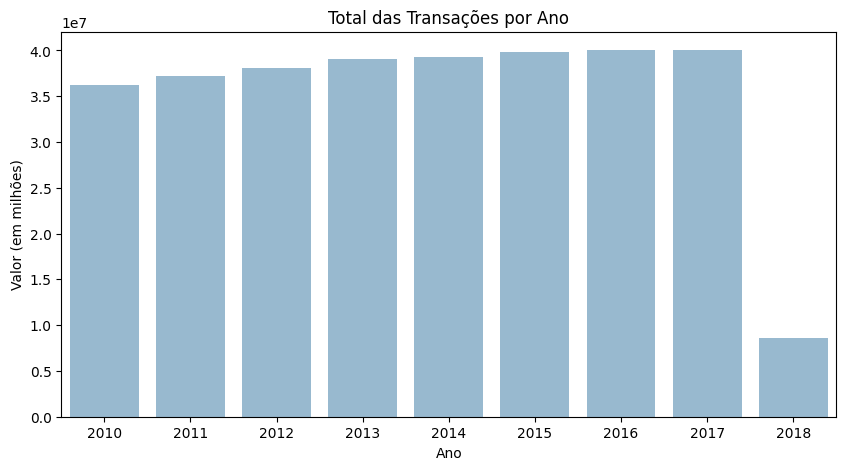

In [57]:
df_time_year = df_time.groupby(['year'])['amount'].sum().reset_index()

plt.subplots(figsize=(10, 5))
plt.title('Total das Transações por Ano')
sns.barplot(data=df_time_year, x='year', y='amount', alpha=0.5)
plt.ylabel('Valor (em milhões)')
plt.xlabel('Ano')

plt.show()

In [58]:
df_time_year = df_time.groupby(['year','target'])['amount'].sum().reset_index()
df_time_year['amount_million'] = df_time_year['amount'] / 1000000
df_time_year.head()

,year,target,amount,amount_million
0,2010,No,35918813.06,35.918813
1,2010,Yes,307936.83,0.307937
2,2011,No,37251408.65,37.251409
3,2011,Yes,4745.40,0.004745
4,2012,No,38004741.12,38.004741


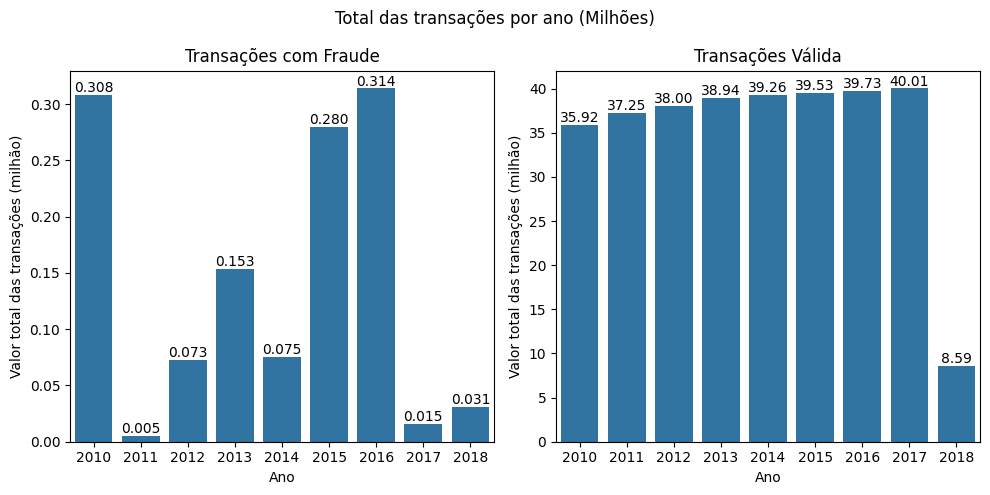

In [59]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Transações com Fraude')
ax1 = sns.barplot(data=df_time_year.query('target == "Yes"'), x='year', y='amount_million')
for patches in ax1.patches:
    ax1.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.subplot(122)
plt.title('Transações Válida')
ax2 = sns.barplot(data=df_time_year.query('target == "No"'), x='year', y='amount_million')
for patches in ax2.patches:
    ax2.annotate(f'{patches.get_height():.2f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.suptitle('Total das transações por ano (Milhões)')
plt.tight_layout()
plt.show()

del df_time_year

In [60]:
df_time_month = df_time.groupby(by=['year_month', 'target'])['amount'].agg(['sum', 'mean', 'std']).reset_index()
df_time_month['year'] = df_time_month['year_month'].dt.year
df_time_month['month'] = df_time_month['year_month'].dt.month
df_time_month['amount_million'] = df_time_month['sum'] / 1000000
df_time_month.head()

,year_month,target,sum,mean,std,year,month,amount_million
0,2010-01-01,No,2929129.96,43.115386,82.574700,2010,1,2.929130
1,2010-01-01,Yes,12253.57,114.519346,203.905324,2010,1,0.012254
2,2010-02-01,No,2713507.09,43.376554,82.612872,2010,2,2.713507
3,2010-02-01,Yes,32488.11,125.436718,305.307738,2010,2,0.032488
4,2010-03-01,No,2984733.64,43.294029,83.392894,2010,3,2.984734


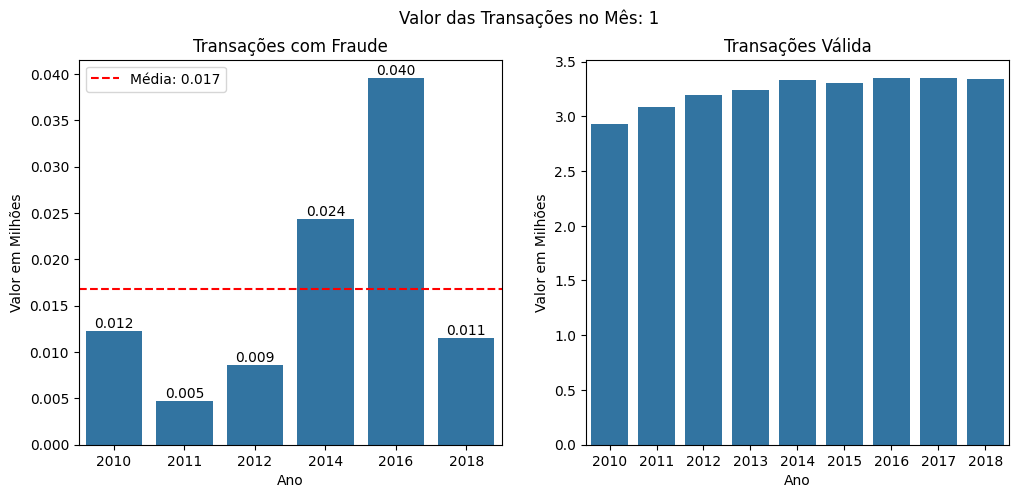

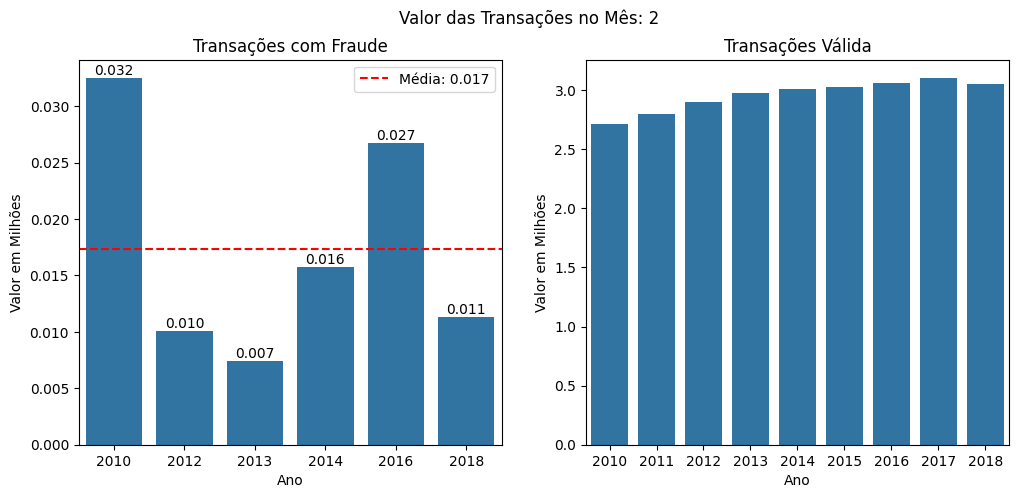

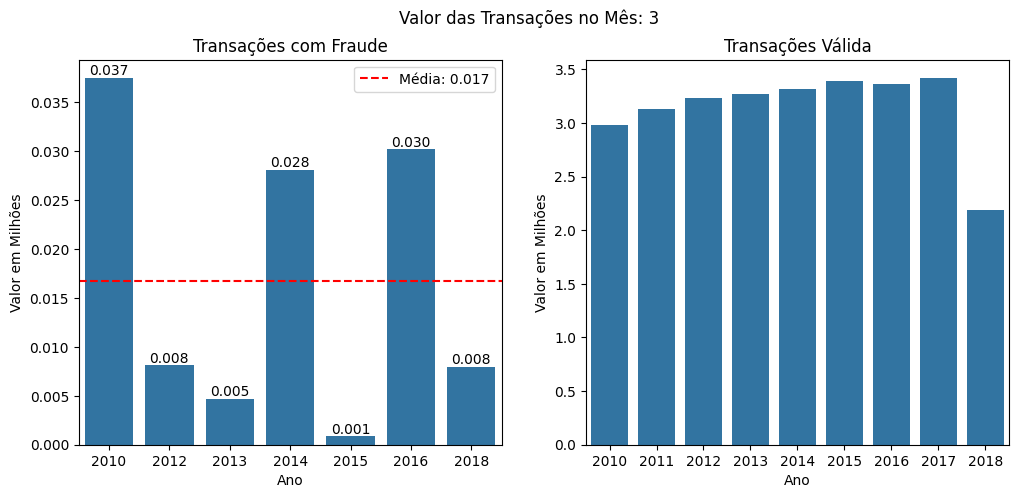

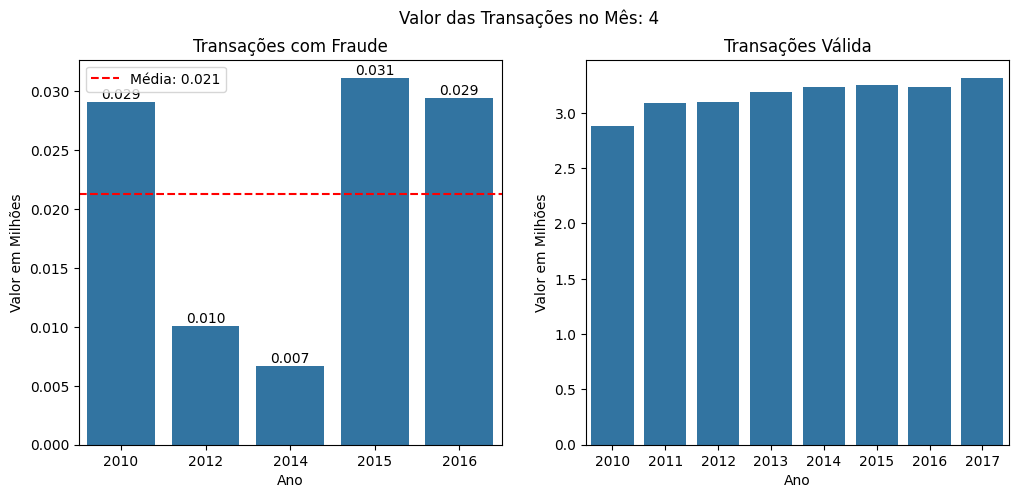

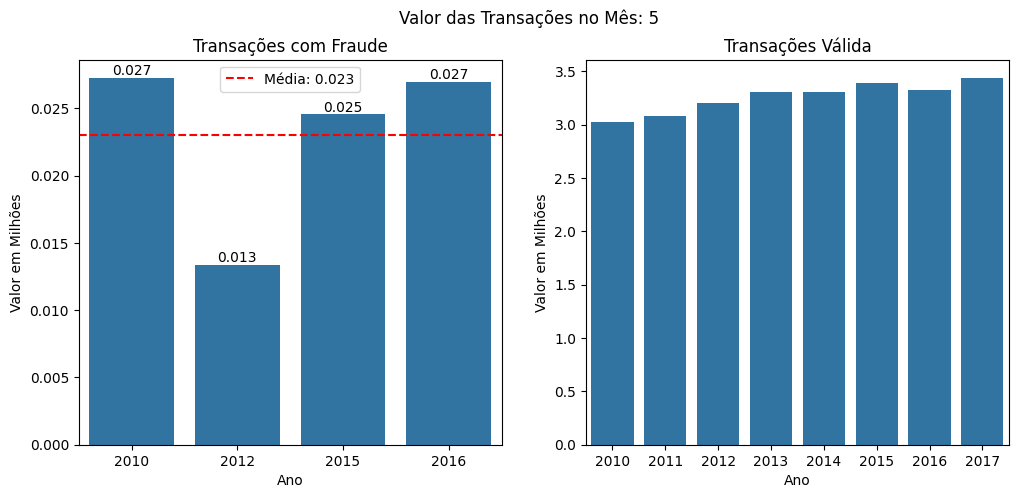

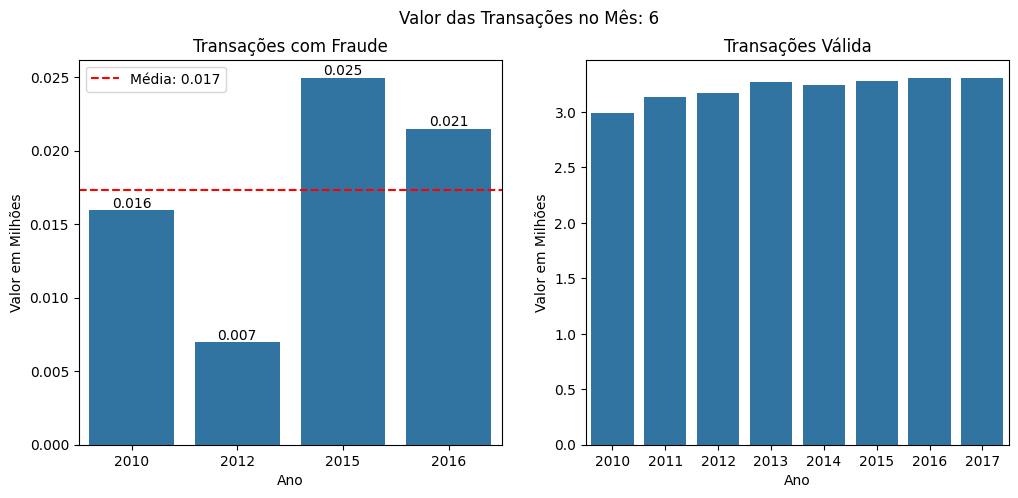

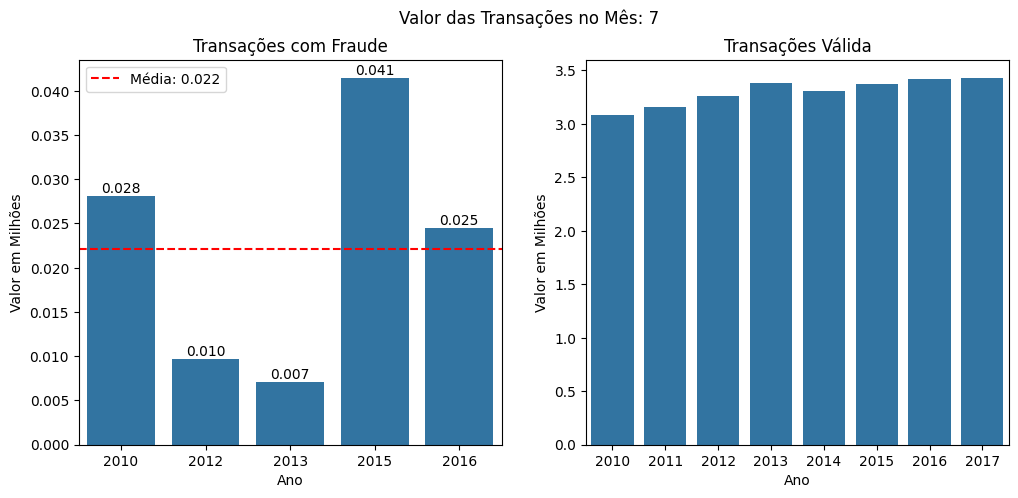

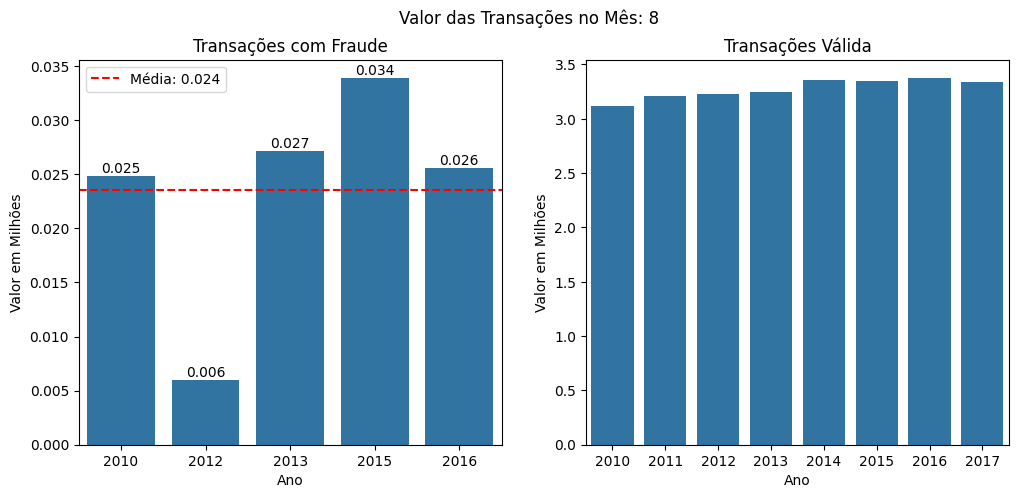

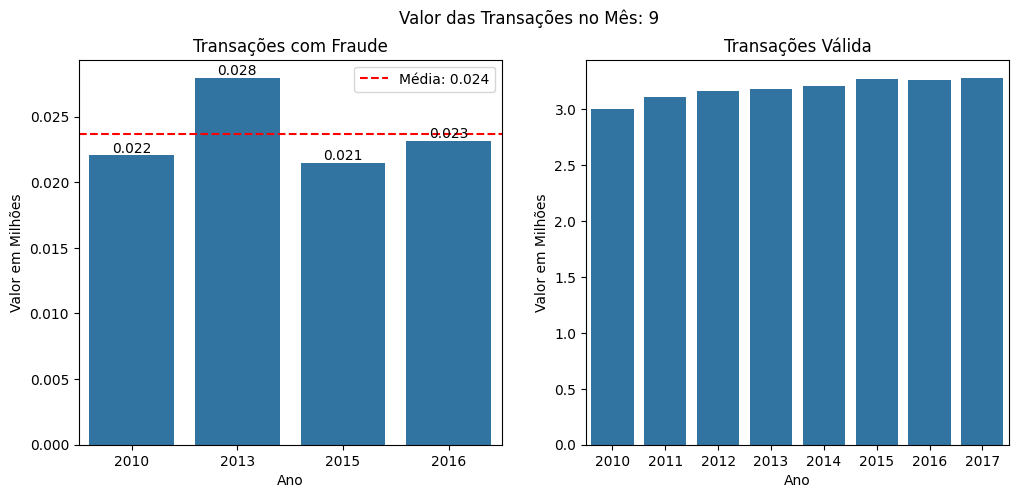

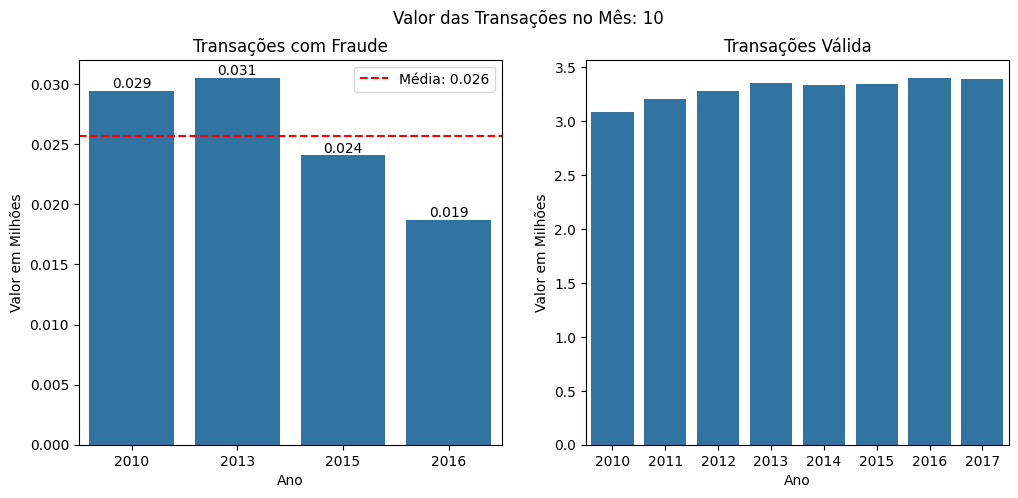

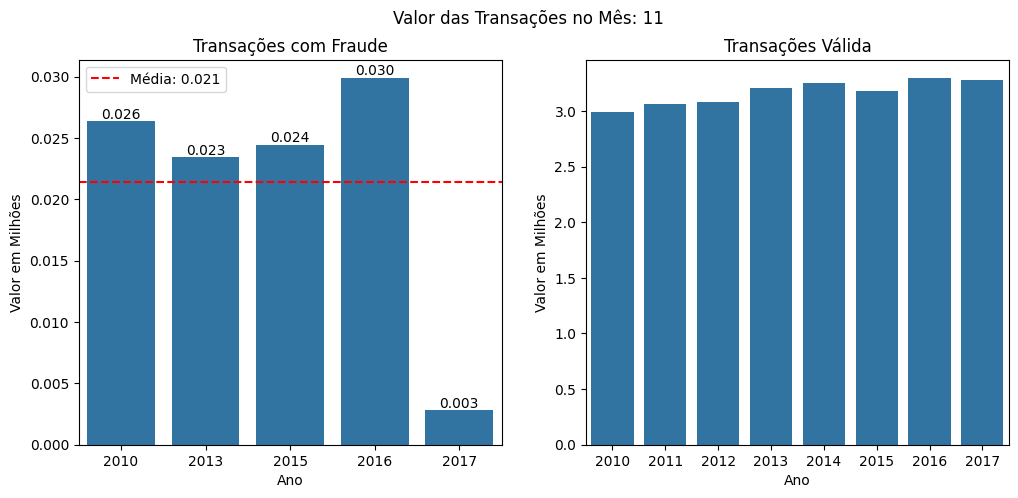

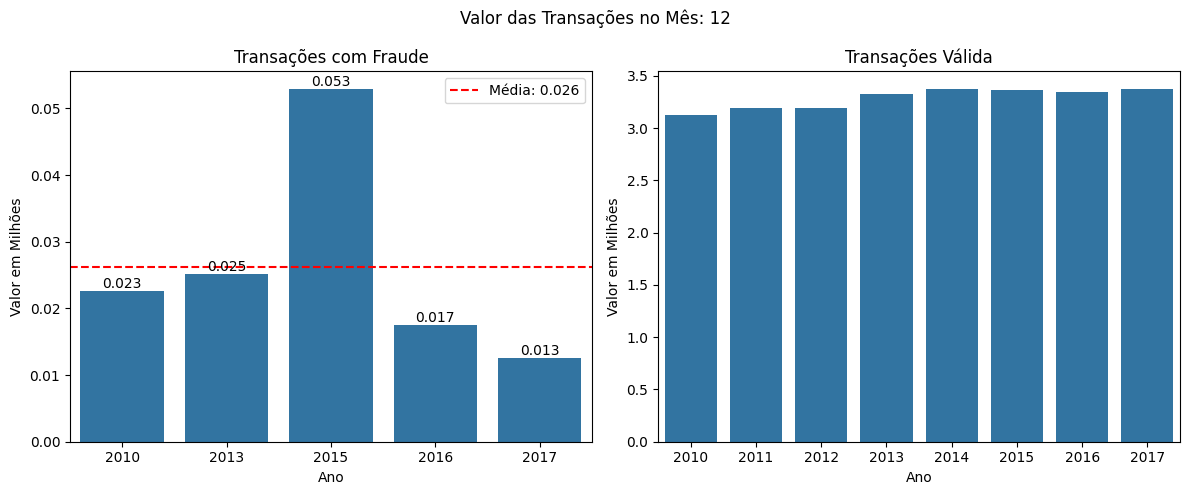

In [61]:
for month in df_time_month['month'].unique():
  df_time_month_month = df_time_month.query('month == @month')

  plt.figure(figsize=(12,5))
  plt.suptitle(f'Valor das Transações no Mês: {month}')

  plt.subplot(121)
  plt.title('Transações com Fraude')

  ax = sns.barplot(data=df_time_month_month.query('target == "Yes"'), x='year', y='amount_million')

  for patches in ax.patches:
    ax.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  mean = df_time_month_month.query('target == "Yes"')['amount_million'].mean()
  ax.axhline(mean, color='red', linestyle='--', label=f'Média: {mean:.3f}')
  ax.legend()

  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

  plt.subplot(122)
  plt.title('Transações Válida')
  sns.barplot(data=df_time_month_month.query('target == "No"'), x='year', y='amount_million')
  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

plt.tight_layout()
plt.show()

* Outubro e Dezembro são os meses com maior média de prejuizo nos anos avaliados (26 mil aproximadamente).
* 2016 foi o ano com maior quantidade e proporção de fraude.